In [1]:
import numpy as np
import sys
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
module_path = os.path.abspath(os.path.join('/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control'))
if module_path not in sys.path:
    sys.path.append(module_path)

from template_configurations import gate_q_env_config
from quantumenvironment import QuantumEnvironment
from gymnasium.wrappers import RescaleAction, ClipAction

import logging
logging.basicConfig(
    level=logging.WARNING,
    format="%(asctime)s INFO %(message)s", # hardcoded INFO level
    datefmt="%Y-%m-%d %H:%M:%S",
    stream=sys.stdout,
)

/Users/lukasvoss/anaconda3/lib/python3.11/site-packages/qiskit_dynamics/dispatch/backends/jax.py:34: UserWarning: The functionality in the perturbation module of Qiskit Dynamics requires a JAX version <= 0.4.6, due to a bug in JAX versions > 0.4.6. For versions 0.4.4, 0.4.5, and 0.4.6, using the perturbation module functionality requires setting os.environ['JAX_JIT_PJIT_API_MERGE'] = '0' before importing JAX or Dynamics.
  warnings.warn(


Circuit context
                 ┌───┐                    ┌───┐
        q_0 -> 0 ┤ H ├──■────■────■────■──┤ H ├
                 └───┘┌─┴─┐  │    │    │  └───┘
        q_1 -> 1 ─────┤ X ├──┼────┼────┼───────
                      └───┘┌─┴─┐  │    │       
        q_2 -> 2 ──────────┤ X ├──┼────┼───────
                           └───┘┌─┴─┐  │       
        q_3 -> 3 ───────────────┤ X ├──┼───────
                                └───┘┌─┴─┐     
        q_4 -> 4 ────────────────────┤ X ├─────
                                     └───┘     
  ancilla_0 -> 5 ──────────────────────────────
                                               
  ancilla_1 -> 6 ──────────────────────────────
                                               
  ancilla_2 -> 7 ──────────────────────────────
                                               
  ancilla_3 -> 8 ──────────────────────────────
                                               
  ancilla_4 -> 9 ──────────────────────────────
                        

In [2]:
# Define the original action space
print('Initial loower bounds:', gate_q_env_config.action_space.low)
print('Initial upper bounds:', gate_q_env_config.action_space.high)

q_env = QuantumEnvironment(gate_q_env_config)

# Apply the RescaleAction wrapper
q_env = ClipAction(q_env)
q_env = RescaleAction(q_env, min_action=-1.0, max_action=1.0)

# Confirm the rescale box dimensions
print('Rescaled lower bounds:', q_env.action_space.low)
print('Rescaled upper bounds:', q_env.action_space.high)

Initial loower bounds: [-3.14 -3.14 -3.14 -3.14 -3.14 -3.14 -3.14]
Initial upper bounds: [3.14 3.14 3.14 3.14 3.14 3.14 3.14]
SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ'],
              coeffs=[ 0.25+0.j, -0.25+0.j, -0.25+0.j,  0.25+0.j])
Rescaled lower bounds: [-1. -1. -1. -1. -1. -1. -1.]
Rescaled upper bounds: [1. 1. 1. 1. 1. 1. 1.]


In [3]:
gate_name = q_env.target['gate'].name
gate_name

/Users/lukasvoss/anaconda3/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.target to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.target` for environment variables or `env.get_wrapper_attr('target')` that will search the reminding wrappers.
  logger.warn(


'cx'

In [4]:
print(q_env.backend)

BraketBackend[SV1]


/Users/lukasvoss/anaconda3/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.backend to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.backend` for environment variables or `env.get_wrapper_attr('backend')` that will search the reminding wrappers.
  logger.warn(


In [5]:
from helper_functions import load_agent_from_yaml_file
ppo_params, network_params  = load_agent_from_yaml_file(file_path='/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/template_configurations/agent_config.yaml')
agent_config = {**ppo_params, **network_params}

In [6]:
agent_config

{'RUN_NAME': 'test',
 'NUM_UPDATES': 1,
 'N_EPOCHS': 8,
 'MINIBATCH_SIZE': 32,
 'LR': 0.0005,
 'GAMMA': 0.99,
 'GAE_LAMBDA': 0.95,
 'ENT_COEF': 0.0,
 'V_COEF': 0.5,
 'GRADIENT_CLIP': 0.5,
 'CLIP_VALUE_LOSS': True,
 'CLIP_VALUE_COEF': 0.2,
 'CLIP_RATIO': 0.2,
 'OPTIMIZER': 'adam',
 'N_UNITS': [64, 64],
 'ACTIVATION': 'tanh',
 'INCLUDE_CRITIC': True,
 'NORMALIZE_ADVANTAGE': True,
 'CHKPT_DIR': 'checkpoints'}

In [7]:
from ppo import make_train_ppo

ppo_agent = make_train_ppo(agent_config, q_env)

/Users/lukasvoss/anaconda3/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.seed to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.seed` for environment variables or `env.get_wrapper_attr('seed')` that will search the reminding wrappers.
  logger.warn(
/Users/lukasvoss/anaconda3/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.batch_size to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.batch_size` for environment variables or `env.get_wrapper_attr('batch_size')` that will search the reminding wrappers.
  logger.warn(
/Users/lukasvoss/anaconda3/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.tgt_instruction_counts to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.tgt_instruction_co

In [8]:
num_updates = 400

In [9]:
training_results = ppo_agent(total_updates=num_updates, print_debug=True, num_prints=40)

100%|██████████| 400/400 [02:10<00:00,  3.07it/s]
/Users/lukasvoss/anaconda3/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.action_history to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.action_history` for environment variables or `env.get_wrapper_attr('action_history')` that will search the reminding wrappers.
  logger.warn(


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time

plt.style.use('ggplot')

In [11]:
avg_reward = training_results['avg_reward']
std_actions = training_results['std_actions']
fidelities = training_results['fidelities']

In [12]:
job_name = f'{gate_name}-gate-calibration-{int(time.time())}-max-fidelity-{round(max(fidelities), 5)}.pickle'

In [13]:
job_name = f'{gate_name}-gate-calibration-{int(time.time())}-max-fidelity-{max(fidelities):4%}.pickle'

with open(job_name, 'wb') as handle:
    pickle.dump(training_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
print(f'Final Gate Fidelity: {fidelities[-1]:.4%}')
print(f'\nMax Gate Fidelity: {max(fidelities):.4%}')

Final Gate Fidelity: 97.9193%

Max Gate Fidelity: 99.4740%


/Users/lukasvoss/anaconda3/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.reward_history to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.reward_history` for environment variables or `env.get_wrapper_attr('reward_history')` that will search the reminding wrappers.
  logger.warn(
/Users/lukasvoss/anaconda3/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.avg_fidelity_history to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.avg_fidelity_history` for environment variables or `env.get_wrapper_attr('avg_fidelity_history')` that will search the reminding wrappers.
  logger.warn(


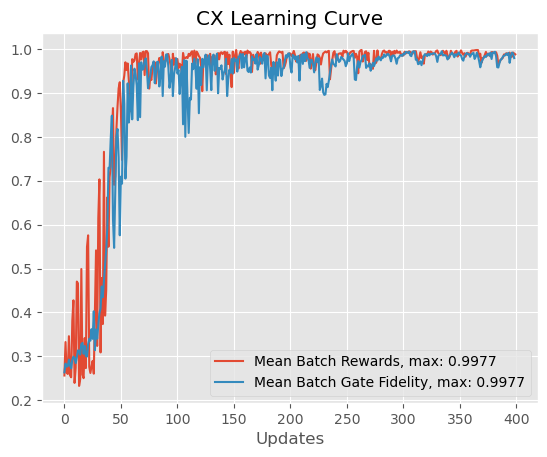

In [15]:
reward_history = np.array(q_env.reward_history)
mean_rewards = np.mean(reward_history, axis=-1)
max_mean = int(np.max(mean_rewards) * 1e4) / 1e4

fidelity = np.array(q_env.avg_fidelity_history)
mean_fidelity = np.mean(fidelity, axis=-1)
max_fidelity = int(np.max(mean_rewards) * 1e4) / 1e4

plt.plot(mean_rewards, label=f'Mean Batch Rewards, max: {max_mean}')
plt.plot(q_env.avg_fidelity_history, label=f'Mean Batch Gate Fidelity, max: {max_fidelity}')
plt.xlabel('Updates')
plt.title('CX Learning Curve')
plt.legend()
plt.show()

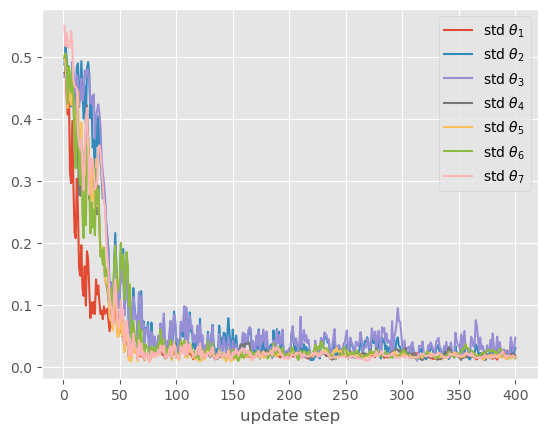

In [16]:
std_actions_componentwise = list(zip(*std_actions))

for ind, param in enumerate(std_actions_componentwise):
    plt.plot(np.arange(1, num_updates+1), param, label=r'std $\theta_{}$'.format(ind+1))

plt.xlabel('update step')
plt.legend()

In [17]:
print('Final action vector:\n', training_results['action_vector'])

Final action vector:
 [-0.15428552 -2.38161     0.75281924  1.5258807   1.548724   -1.606797
  1.5744786 ]
